In [172]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch
import time
from pandas.plotting import scatter_matrix
from datetime import datetime as dt
import rioxarray as rxr
import xarray as xr

# torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Import Data

In [133]:
gauge_num = "09037500"
df_lstm = pd.read_csv(
    "../Streamflow_Data/Streamflow_clean_" + gauge_num + ".csv", 
    index_col = "Date", 
    parse_dates=True
)
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14062 entries, 1981-10-01 to 2020-03-31
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tmmx_mean             14062 non-null  float64
 1   log_tmmx_var          14062 non-null  float64
 2   tmmn_mean             14062 non-null  float64
 3   log_tmmn_var          14062 non-null  float64
 4   pr_mean               14062 non-null  float64
 5   pr_var                14062 non-null  float64
 6   pr_sum                14062 non-null  float64
 7   SPEI_mean             14062 non-null  float64
 8   SPEI_stdev            14062 non-null  float64
 9   pet_mean              14062 non-null  float64
 10  pet_var               14062 non-null  float64
 11  pet_sum               14062 non-null  float64
 12  SoilM_0_10cm_mean     14062 non-null  float64
 13  SoilM_0_10cm_stdev    14062 non-null  float64
 14  SoilM_10_40cm_mean    14062 non-null  float64
 15  So

In [134]:
df_lstm.describe()

,tmmx_mean,log_tmmx_var,tmmn_mean,log_tmmn_var,pr_mean,pr_var,pr_sum,SPEI_mean,SPEI_stdev,pet_mean,...,pet_sum,SoilM_0_10cm_mean,SoilM_0_10cm_stdev,SoilM_10_40cm_mean,SoilM_10_40cm_stdev,SoilM_40_100cm_mean,SoilM_40_100cm_stdev,SWE_mean,SWE_stdev,weibull_jd_30d_avg
count,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,...,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000,14062.000000
mean,39.233871,0.621345,36.804132,0.621345,1.844382,1.132257,53.623183,-0.018995,-0.018995,2.749324,...,79.240976,27.670399,3.293829,73.023107,8.471557,135.220614,10.934260,83.641148,40.522235,50.281539
std,9.318694,0.250870,8.149847,0.250870,3.067052,4.054328,89.398747,0.901918,0.901918,1.598216,...,46.076612,6.548800,2.305301,12.628244,4.486704,16.024198,4.137096,93.135862,46.285350,28.134417
min,10.700000,-0.522879,5.600000,-0.522879,0.000000,0.000000,0.000000,-2.090000,-2.090000,0.000000,...,1.000000,15.740000,0.460000,50.410000,1.530000,107.720000,4.100000,0.000000,0.000000,0.080580
25%,31.600000,0.447158,30.500000,0.447158,0.000000,0.000000,0.000000,-0.646000,-0.646000,1.300000,...,37.200000,20.810000,1.430000,62.060000,4.460000,123.390000,7.910000,0.000000,0.000000,26.449478
50%,38.800000,0.698970,37.200000,0.698970,0.600000,0.100000,17.500000,-0.032000,-0.032000,2.500000,...,72.650000,29.290000,2.740000,71.740000,7.380000,131.340000,10.110000,47.510000,25.510000,50.054819
75%,47.900000,0.826075,44.000000,0.826075,2.300000,0.600000,67.500000,0.604000,0.604000,4.100000,...,117.475000,33.480000,4.550000,80.900000,12.030000,144.057500,13.097500,152.480000,63.600000,74.133763
max,57.500000,1.262451,52.300000,1.262451,43.300000,164.600000,1257.500000,2.090000,2.090000,7.900000,...,228.000000,40.210000,12.510000,113.110000,22.620000,184.550000,28.440000,390.230000,230.680000,99.919420


In [135]:
df_lstm.head(5)

,tmmx_mean,log_tmmx_var,tmmn_mean,log_tmmn_var,pr_mean,pr_var,pr_sum,SPEI_mean,SPEI_stdev,pet_mean,...,pet_sum,SoilM_0_10cm_mean,SoilM_0_10cm_stdev,SoilM_10_40cm_mean,SoilM_10_40cm_stdev,SoilM_40_100cm_mean,SoilM_40_100cm_stdev,SWE_mean,SWE_stdev,weibull_jd_30d_avg
Date,,,,,,,,,,,,,,,,,,,,,
1981-10-01,45.1,0.799341,41.1,0.799341,0.0,0.0,0.0,-0.790,-0.790,2.9,...,83.1,19.99,1.01,57.65,3.02,122.61,6.58,0.00,0.00,33.521354
1981-10-02,43.5,0.716003,43.4,0.716003,1.3,0.0,38.6,-0.700,-0.700,2.3,...,67.7,20.12,0.97,57.36,3.00,122.43,6.54,0.00,0.00,29.814666
1981-10-03,38.5,0.770852,41.1,0.770852,2.7,0.2,79.2,-0.602,-0.602,1.8,...,51.3,20.42,0.89,57.51,2.94,122.26,6.51,0.00,0.00,33.440774
1981-10-04,40.9,0.707570,40.7,0.707570,3.0,0.2,86.8,-0.504,-0.504,2.2,...,62.4,20.81,0.95,57.62,3.03,122.11,6.48,0.01,0.12,46.655923
1981-10-05,39.6,0.806180,41.2,0.806180,1.4,0.0,40.4,-0.406,-0.406,2.5,...,71.5,21.12,1.08,57.82,3.15,121.97,6.46,0.07,0.36,53.988719


In [136]:
clean_tiles = pd.read_csv('../Landsat_Data/Clear_Tiles_Williams_Fork_Reservoir.csv', names=['Files'], dtype='string')
clean_tiles

,Files
0,LT05_CU_011009_19840528_20190206_C01_V01_INWM.tif
1,LT05_CU_011009_19840613_20190604_C01_V01_INWM.tif
2,LT05_CU_011009_19840629_20190604_C01_V01_INWM.tif
3,LT05_CU_011009_19860603_20190603_C01_V01_INWM.tif
4,LT05_CU_011009_19860619_20190603_C01_V01_INWM.tif
...,...
150,LC08_CU_011009_20210603_20210616_C01_V01_INWM.tif
151,LC08_CU_011009_20210705_20210715_C01_V01_INWM.tif
152,LC08_CU_011009_20210907_20210921_C01_V01_INWM.tif
153,LC08_CU_011009_20210923_20211002_C01_V01_INWM.tif


In [137]:
clean_tiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Files   155 non-null    string
dtypes: string(1)
memory usage: 1.3 KB


## Find If Tiles Are During Drought

In [7]:
df_drought_events = pd.read_csv("../Streamflow_Data/Streamflow_Drought_Data_CRB/Streamflow_Drought_Events/weibull_jd_Drought_Properties.csv")
df_drought_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107916 entries, 0 to 107915
Data columns (total 17 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   drought_id                                          107916 non-null  int64  
 1   severity                                            107916 non-null  float64
 2   mean_intensity                                      107916 non-null  float64
 3   max_intensity                                       107916 non-null  float64
 4   duration                                            107916 non-null  int64  
 5   start                                               107916 non-null  object 
 6   end                                                 107916 non-null  object 
 7   min_flow_cfs                                        107916 non-null  float64
 8   mean_flow_cfs                                       107916 non-n

In [8]:
gauge = '09037500'
df_site = df_drought_events.loc[df_drought_events['site'] == 'SW' + gauge]
df_site

,drought_id,severity,mean_intensity,max_intensity,duration,start,end,min_flow_cfs,mean_flow_cfs,max_flow_cfs,flow_deficit_cfs,threshold,site,dropped_zeros,previous_end,days_since_previous_drought,has_the_potential_to_be_impacted_by_missing_values
36559,1,33.292683,2.439024,2.439024,13,1980-04-07,1980-04-19,28.0000,29.043962,35.1429,80.704935,5,SW09037500,False,NaN,NaN,False
36560,3,124.756098,3.019744,2.439024,63,1981-01-01,1981-03-04,19.2857,23.736962,28.8571,273.199645,5,SW09037500,False,1980-04-19,257.0,False
36561,5,100.000000,2.500000,2.439024,40,1981-04-21,1981-05-30,10.1857,23.700360,100.2857,1316.015460,5,SW09037500,False,1981-03-04,48.0,False
36562,7,0.975610,4.878049,4.878049,8,1981-11-26,1981-12-03,27.5714,28.357138,30.4286,13.381510,5,SW09037500,False,1981-05-30,180.0,False
36563,8,23.658537,3.310105,2.439024,14,1981-12-10,1981-12-23,28.4286,29.142850,29.8571,18.522180,5,SW09037500,False,1981-12-03,7.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36822,134,170.000000,21.052632,14.634146,19,2018-03-05,2018-03-23,30.1857,31.512026,34.3429,23.548530,30,SW09037500,False,2017-10-03,153.0,False
36823,135,5314.146341,12.046803,2.439024,296,2018-06-11,2019-04-07,10.0614,41.650366,405.8571,5280.580140,30,SW09037500,False,2018-03-23,80.0,False
36824,136,19.512195,28.048780,26.829268,10,2019-05-27,2019-06-05,245.0000,260.885730,304.7143,321.614140,30,SW09037500,False,2019-04-07,50.0,False
36825,137,143.170732,22.464698,12.195122,19,2019-09-23,2019-10-11,23.1857,25.721784,37.1714,172.986030,30,SW09037500,False,2019-06-05,110.0,False


In [9]:
start = pd.to_datetime(df_site['start']).to_list()
start

[Timestamp('1980-04-07 00:00:00'),
 Timestamp('1981-01-01 00:00:00'),
 Timestamp('1981-04-21 00:00:00'),
 Timestamp('1981-11-26 00:00:00'),
 Timestamp('1981-12-10 00:00:00'),
 Timestamp('1982-04-02 00:00:00'),
 Timestamp('1982-05-20 00:00:00'),
 Timestamp('1983-04-12 00:00:00'),
 Timestamp('1987-11-18 00:00:00'),
 Timestamp('1988-08-05 00:00:00'),
 Timestamp('1988-10-24 00:00:00'),
 Timestamp('1989-09-05 00:00:00'),
 Timestamp('1990-02-21 00:00:00'),
 Timestamp('1994-12-20 00:00:00'),
 Timestamp('2000-07-29 00:00:00'),
 Timestamp('2002-03-25 00:00:00'),
 Timestamp('2002-04-27 00:00:00'),
 Timestamp('2002-05-27 00:00:00'),
 Timestamp('2002-06-08 00:00:00'),
 Timestamp('2002-10-10 00:00:00'),
 Timestamp('2002-11-01 00:00:00'),
 Timestamp('2010-10-02 00:00:00'),
 Timestamp('2010-10-17 00:00:00'),
 Timestamp('2012-05-30 00:00:00'),
 Timestamp('2012-10-06 00:00:00'),
 Timestamp('2013-04-20 00:00:00'),
 Timestamp('2017-09-11 00:00:00'),
 Timestamp('2018-08-15 00:00:00'),
 Timestamp('2018-11-

In [10]:
end = pd.to_datetime(df_site['end']).to_list()
end

[Timestamp('1980-04-19 00:00:00'),
 Timestamp('1981-03-04 00:00:00'),
 Timestamp('1981-05-30 00:00:00'),
 Timestamp('1981-12-03 00:00:00'),
 Timestamp('1981-12-23 00:00:00'),
 Timestamp('1982-04-11 00:00:00'),
 Timestamp('1982-05-26 00:00:00'),
 Timestamp('1983-04-19 00:00:00'),
 Timestamp('1987-12-10 00:00:00'),
 Timestamp('1988-08-29 00:00:00'),
 Timestamp('1988-11-19 00:00:00'),
 Timestamp('1989-09-11 00:00:00'),
 Timestamp('1990-04-07 00:00:00'),
 Timestamp('1995-02-20 00:00:00'),
 Timestamp('2000-08-05 00:00:00'),
 Timestamp('2002-04-01 00:00:00'),
 Timestamp('2002-05-19 00:00:00'),
 Timestamp('2002-06-02 00:00:00'),
 Timestamp('2002-08-07 00:00:00'),
 Timestamp('2002-10-16 00:00:00'),
 Timestamp('2002-11-08 00:00:00'),
 Timestamp('2010-10-06 00:00:00'),
 Timestamp('2010-10-24 00:00:00'),
 Timestamp('2012-07-24 00:00:00'),
 Timestamp('2012-10-30 00:00:00'),
 Timestamp('2013-04-26 00:00:00'),
 Timestamp('2017-09-28 00:00:00'),
 Timestamp('2018-10-09 00:00:00'),
 Timestamp('2018-11-

In [11]:
dates = []
for tile in clean_tiles['Files']:
    string_date = tile.split('_')[3]
    date = dt.strptime(string_date, '%Y%m%d')
    dates.append(date)
dates

[datetime.datetime(1984, 5, 28, 0, 0),
 datetime.datetime(1984, 6, 13, 0, 0),
 datetime.datetime(1984, 6, 29, 0, 0),
 datetime.datetime(1986, 6, 3, 0, 0),
 datetime.datetime(1986, 6, 19, 0, 0),
 datetime.datetime(1986, 7, 21, 0, 0),
 datetime.datetime(1986, 8, 6, 0, 0),
 datetime.datetime(1986, 10, 9, 0, 0),
 datetime.datetime(1987, 6, 22, 0, 0),
 datetime.datetime(1987, 7, 8, 0, 0),
 datetime.datetime(1987, 7, 24, 0, 0),
 datetime.datetime(1987, 9, 10, 0, 0),
 datetime.datetime(1987, 9, 26, 0, 0),
 datetime.datetime(1988, 5, 23, 0, 0),
 datetime.datetime(1988, 6, 8, 0, 0),
 datetime.datetime(1988, 6, 24, 0, 0),
 datetime.datetime(1988, 7, 10, 0, 0),
 datetime.datetime(1988, 8, 11, 0, 0),
 datetime.datetime(1988, 8, 27, 0, 0),
 datetime.datetime(1989, 7, 13, 0, 0),
 datetime.datetime(1989, 9, 15, 0, 0),
 datetime.datetime(1989, 10, 1, 0, 0),
 datetime.datetime(1990, 9, 2, 0, 0),
 datetime.datetime(1990, 10, 4, 0, 0),
 datetime.datetime(1991, 6, 17, 0, 0),
 datetime.datetime(1991, 7, 3,

In [12]:
in_drought = []
for i in range(0, len(dates)):
    for j in range(0, len(start)):
        if (dates[i] > start[j]) and (dates[i] < end[j]):
            in_drought.append(dates[i])
            break;
len(in_drought)

36

In [13]:
in_drought

[datetime.datetime(1987, 6, 22, 0, 0),
 datetime.datetime(1987, 7, 8, 0, 0),
 datetime.datetime(1987, 7, 24, 0, 0),
 datetime.datetime(1987, 9, 10, 0, 0),
 datetime.datetime(1988, 8, 11, 0, 0),
 datetime.datetime(1988, 8, 27, 0, 0),
 datetime.datetime(1989, 7, 13, 0, 0),
 datetime.datetime(1990, 9, 2, 0, 0),
 datetime.datetime(1992, 6, 19, 0, 0),
 datetime.datetime(1994, 6, 25, 0, 0),
 datetime.datetime(1994, 7, 11, 0, 0),
 datetime.datetime(1994, 8, 12, 0, 0),
 datetime.datetime(1996, 8, 17, 0, 0),
 datetime.datetime(1999, 5, 22, 0, 0),
 datetime.datetime(2000, 9, 13, 0, 0),
 datetime.datetime(2001, 6, 28, 0, 0),
 datetime.datetime(2001, 10, 2, 0, 0),
 datetime.datetime(2002, 7, 1, 0, 0),
 datetime.datetime(2002, 7, 17, 0, 0),
 datetime.datetime(2002, 10, 21, 0, 0),
 datetime.datetime(2003, 7, 20, 0, 0),
 datetime.datetime(2004, 6, 20, 0, 0),
 datetime.datetime(2004, 7, 6, 0, 0),
 datetime.datetime(2004, 9, 8, 0, 0),
 datetime.datetime(2006, 6, 26, 0, 0),
 datetime.datetime(2007, 9, 1

36 of the landsat observations are from within a drought. That means our target variable split is 36/155.

## Obtain Data for CNN

In [14]:
directory = '../Landsat_Data/DSWE_CRB/'

In [15]:
tiles = []
dates = []
for tile in clean_tiles['Files']:
    tif_file = rxr.open_rasterio(directory + tile)
    tif_file_sliced = tif_file.sel(x=slice(-864520, -854520), y=slice(1937400, 1927395))
    
    # Find date within tile filename
    tile_date = tile.split('_')[3]
    tile_date = [dt(int(tile_date[:4]), int(tile_date[4:6]), int(tile_date[6:8])).date()]
        
    # Add date as a dimension to tile DataArray
    time_da = xr.DataArray(tile_date, [('time', tile_date[0:1])])
    tif_file = tif_file_sliced.expand_dims(time=time_da)
    
    dates.append(tile_date)
    tiles.append(tif_file)
len(tiles)

155

In [17]:
tiles[0].time.values[0]

datetime.date(1984, 5, 28)

In [18]:
tiles[0].values.shape

(1, 1, 334, 334)

(array([0, 1, 2, 3, 4], dtype=uint8),
 array([104999,   4566,     33,    250,   1708]))

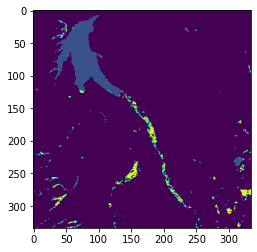

In [19]:
plt.imshow(tiles[0][0][0])
np.unique(tiles[0][0][0].values, return_counts=True)

## Preprocess Data for CNN

In [20]:
gauge_num = "09037500"
df_cnn = pd.read_csv(
    "../Streamflow_Data/Streamflow_clean_" + gauge_num + ".csv", 
    index_col = "Date", 
    parse_dates=True
)
df_cnn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14062 entries, 1981-10-01 to 2020-03-31
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tmmx_mean             14062 non-null  float64
 1   log_tmmx_var          14062 non-null  float64
 2   tmmn_mean             14062 non-null  float64
 3   log_tmmn_var          14062 non-null  float64
 4   pr_mean               14062 non-null  float64
 5   pr_var                14062 non-null  float64
 6   pr_sum                14062 non-null  float64
 7   SPEI_mean             14062 non-null  float64
 8   SPEI_stdev            14062 non-null  float64
 9   pet_mean              14062 non-null  float64
 10  pet_var               14062 non-null  float64
 11  pet_sum               14062 non-null  float64
 12  SoilM_0_10cm_mean     14062 non-null  float64
 13  SoilM_0_10cm_stdev    14062 non-null  float64
 14  SoilM_10_40cm_mean    14062 non-null  float64
 15  So

In [21]:
periods = -3
df_cnn["weibull_jd_30d_avg_" + str(periods)[1:]] = df_cnn["weibull_jd_30d_avg"].shift(periods=periods)
df_cnn = df_cnn.drop("weibull_jd_30d_avg", axis=1)
df_cnn.tail(10)

,tmmx_mean,log_tmmx_var,tmmn_mean,log_tmmn_var,pr_mean,pr_var,pr_sum,SPEI_mean,SPEI_stdev,pet_mean,...,pet_sum,SoilM_0_10cm_mean,SoilM_0_10cm_stdev,SoilM_10_40cm_mean,SoilM_10_40cm_stdev,SoilM_40_100cm_mean,SoilM_40_100cm_stdev,SWE_mean,SWE_stdev,weibull_jd_30d_avg_1
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,31.0,0.397940,32.7,0.397940,4.9,2.9,145.0,-0.312,-0.312,1.6,...,46.4,34.28,4.66,80.41,16.68,129.98,8.38,268.25,80.41,41.176471
2020-03-23,33.9,0.380211,31.6,0.380211,5.1,4.3,149.3,-0.208,-0.208,1.9,...,55.8,34.26,4.65,80.47,16.55,130.10,8.41,271.24,81.83,52.135375
2020-03-24,36.0,0.602060,36.5,0.602060,0.5,0.6,13.9,-0.104,-0.104,2.6,...,75.0,34.30,4.69,80.58,16.52,130.21,8.43,275.16,83.41,56.325544
2020-03-25,36.4,0.556303,38.5,0.556303,0.0,0.0,0.0,0.000,0.000,3.0,...,86.8,34.32,4.72,80.67,16.46,130.34,8.46,276.11,85.02,56.728445
2020-03-26,38.6,0.491362,35.3,0.491362,0.0,0.0,0.0,0.108,0.108,3.1,...,90.8,34.36,4.81,80.81,16.46,130.46,8.49,276.18,86.85,55.358582
2020-03-27,31.2,0.505150,30.0,0.505150,7.5,6.3,222.3,0.216,0.216,1.6,...,46.1,34.38,4.90,80.98,16.50,130.60,8.54,276.10,87.40,45.527800
2020-03-28,27.3,0.643453,27.5,0.643453,0.3,0.2,7.1,0.324,0.324,1.3,...,36.6,34.31,4.85,81.06,16.38,130.74,8.58,280.59,89.11,40.290089
2020-03-29,32.1,0.707570,28.6,0.707570,0.8,0.9,24.1,0.432,0.432,1.8,...,50.2,34.26,4.81,81.09,16.20,130.85,8.60,281.15,89.42,41.821112
2020-03-30,34.1,0.447158,33.6,0.447158,0.4,0.3,8.9,0.540,0.540,2.0,...,58.3,34.23,4.81,81.18,16.15,130.97,8.61,282.60,89.21,44.883159


In [22]:
df_cnn = df_cnn[df_cnn["weibull_jd_30d_avg_" + str(periods)[1:]].notnull()]
df_cnn.tail(10)

,tmmx_mean,log_tmmx_var,tmmn_mean,log_tmmn_var,pr_mean,pr_var,pr_sum,SPEI_mean,SPEI_stdev,pet_mean,...,pet_sum,SoilM_0_10cm_mean,SoilM_0_10cm_stdev,SoilM_10_40cm_mean,SoilM_10_40cm_stdev,SoilM_40_100cm_mean,SoilM_40_100cm_stdev,SWE_mean,SWE_stdev,weibull_jd_30d_avg_1
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-21,33.8,0.591065,30.9,0.591065,2.7,0.7,79.0,-0.416,-0.416,1.8,...,53.3,34.32,4.67,80.33,16.76,129.86,8.36,265.15,79.78,55.761483
2020-03-22,31.0,0.397940,32.7,0.397940,4.9,2.9,145.0,-0.312,-0.312,1.6,...,46.4,34.28,4.66,80.41,16.68,129.98,8.38,268.25,80.41,41.176471
2020-03-23,33.9,0.380211,31.6,0.380211,5.1,4.3,149.3,-0.208,-0.208,1.9,...,55.8,34.26,4.65,80.47,16.55,130.10,8.41,271.24,81.83,52.135375
2020-03-24,36.0,0.602060,36.5,0.602060,0.5,0.6,13.9,-0.104,-0.104,2.6,...,75.0,34.30,4.69,80.58,16.52,130.21,8.43,275.16,83.41,56.325544
2020-03-25,36.4,0.556303,38.5,0.556303,0.0,0.0,0.0,0.000,0.000,3.0,...,86.8,34.32,4.72,80.67,16.46,130.34,8.46,276.11,85.02,56.728445
2020-03-26,38.6,0.491362,35.3,0.491362,0.0,0.0,0.0,0.108,0.108,3.1,...,90.8,34.36,4.81,80.81,16.46,130.46,8.49,276.18,86.85,55.358582
2020-03-27,31.2,0.505150,30.0,0.505150,7.5,6.3,222.3,0.216,0.216,1.6,...,46.1,34.38,4.90,80.98,16.50,130.60,8.54,276.10,87.40,45.527800
2020-03-28,27.3,0.643453,27.5,0.643453,0.3,0.2,7.1,0.324,0.324,1.3,...,36.6,34.31,4.85,81.06,16.38,130.74,8.58,280.59,89.11,40.290089
2020-03-29,32.1,0.707570,28.6,0.707570,0.8,0.9,24.1,0.432,0.432,1.8,...,50.2,34.26,4.81,81.09,16.20,130.85,8.60,281.15,89.42,41.821112


## Data Shifting for Forecasting

The "shift" function allows us to easily take our target variable column and shift it a certain number of rows in order to offset them for use as prediction values. This means that the model will be attempting to use historical data to predict a future value. The "periods" variable can be adjusted to change the number of days out you are forecasting for.

In [138]:
periods = -3
df_lstm["weibull_jd_30d_avg_" + str(periods)[1:]] = df_lstm["weibull_jd_30d_avg"].shift(periods=periods)
# df_lstm = df_lstm.drop("weibull_jd_30d_avg", axis=1)
df_lstm.tail(10)

,tmmx_mean,log_tmmx_var,tmmn_mean,log_tmmn_var,pr_mean,pr_var,pr_sum,SPEI_mean,SPEI_stdev,pet_mean,...,SoilM_0_10cm_mean,SoilM_0_10cm_stdev,SoilM_10_40cm_mean,SoilM_10_40cm_stdev,SoilM_40_100cm_mean,SoilM_40_100cm_stdev,SWE_mean,SWE_stdev,weibull_jd_30d_avg,weibull_jd_30d_avg_3
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,31.0,0.397940,32.7,0.397940,4.9,2.9,145.0,-0.312,-0.312,1.6,...,34.28,4.66,80.41,16.68,129.98,8.38,268.25,80.41,55.761483,56.325544
2020-03-23,33.9,0.380211,31.6,0.380211,5.1,4.3,149.3,-0.208,-0.208,1.9,...,34.26,4.65,80.47,16.55,130.10,8.41,271.24,81.83,41.176471,56.728445
2020-03-24,36.0,0.602060,36.5,0.602060,0.5,0.6,13.9,-0.104,-0.104,2.6,...,34.30,4.69,80.58,16.52,130.21,8.43,275.16,83.41,52.135375,55.358582
2020-03-25,36.4,0.556303,38.5,0.556303,0.0,0.0,0.0,0.000,0.000,3.0,...,34.32,4.72,80.67,16.46,130.34,8.46,276.11,85.02,56.325544,45.527800
2020-03-26,38.6,0.491362,35.3,0.491362,0.0,0.0,0.0,0.108,0.108,3.1,...,34.36,4.81,80.81,16.46,130.46,8.49,276.18,86.85,56.728445,40.290089
2020-03-27,31.2,0.505150,30.0,0.505150,7.5,6.3,222.3,0.216,0.216,1.6,...,34.38,4.90,80.98,16.50,130.60,8.54,276.10,87.40,55.358582,41.821112
2020-03-28,27.3,0.643453,27.5,0.643453,0.3,0.2,7.1,0.324,0.324,1.3,...,34.31,4.85,81.06,16.38,130.74,8.58,280.59,89.11,45.527800,44.883159
2020-03-29,32.1,0.707570,28.6,0.707570,0.8,0.9,24.1,0.432,0.432,1.8,...,34.26,4.81,81.09,16.20,130.85,8.60,281.15,89.42,40.290089,NaN
2020-03-30,34.1,0.447158,33.6,0.447158,0.4,0.3,8.9,0.540,0.540,2.0,...,34.23,4.81,81.18,16.15,130.97,8.61,282.60,89.21,41.821112,NaN


In [139]:
df_lstm = df_lstm[df_lstm["weibull_jd_30d_avg_" + str(periods)[1:]].notnull()]

In [140]:
df_lstm.tail(10)

,tmmx_mean,log_tmmx_var,tmmn_mean,log_tmmn_var,pr_mean,pr_var,pr_sum,SPEI_mean,SPEI_stdev,pet_mean,...,SoilM_0_10cm_mean,SoilM_0_10cm_stdev,SoilM_10_40cm_mean,SoilM_10_40cm_stdev,SoilM_40_100cm_mean,SoilM_40_100cm_stdev,SWE_mean,SWE_stdev,weibull_jd_30d_avg,weibull_jd_30d_avg_3
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-19,29.9,0.477121,32.9,0.477121,11.0,12.5,321.5,-0.818,-0.818,1.3,...,34.30,4.56,80.08,16.83,129.59,8.26,254.70,75.69,68.331990,55.761483
2020-03-20,31.1,0.397940,30.6,0.397940,3.5,3.2,104.7,-0.520,-0.520,1.4,...,34.35,4.68,80.26,16.89,129.73,8.31,261.96,78.34,60.112812,41.176471
2020-03-21,33.8,0.591065,30.9,0.591065,2.7,0.7,79.0,-0.416,-0.416,1.8,...,34.32,4.67,80.33,16.76,129.86,8.36,265.15,79.78,57.937147,52.135375
2020-03-22,31.0,0.397940,32.7,0.397940,4.9,2.9,145.0,-0.312,-0.312,1.6,...,34.28,4.66,80.41,16.68,129.98,8.38,268.25,80.41,55.761483,56.325544
2020-03-23,33.9,0.380211,31.6,0.380211,5.1,4.3,149.3,-0.208,-0.208,1.9,...,34.26,4.65,80.47,16.55,130.10,8.41,271.24,81.83,41.176471,56.728445
2020-03-24,36.0,0.602060,36.5,0.602060,0.5,0.6,13.9,-0.104,-0.104,2.6,...,34.30,4.69,80.58,16.52,130.21,8.43,275.16,83.41,52.135375,55.358582
2020-03-25,36.4,0.556303,38.5,0.556303,0.0,0.0,0.0,0.000,0.000,3.0,...,34.32,4.72,80.67,16.46,130.34,8.46,276.11,85.02,56.325544,45.527800
2020-03-26,38.6,0.491362,35.3,0.491362,0.0,0.0,0.0,0.108,0.108,3.1,...,34.36,4.81,80.81,16.46,130.46,8.49,276.18,86.85,56.728445,40.290089
2020-03-27,31.2,0.505150,30.0,0.505150,7.5,6.3,222.3,0.216,0.216,1.6,...,34.38,4.90,80.98,16.50,130.60,8.54,276.10,87.40,55.358582,41.821112


In [141]:
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14059 entries, 1981-10-01 to 2020-03-28
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tmmx_mean             14059 non-null  float64
 1   log_tmmx_var          14059 non-null  float64
 2   tmmn_mean             14059 non-null  float64
 3   log_tmmn_var          14059 non-null  float64
 4   pr_mean               14059 non-null  float64
 5   pr_var                14059 non-null  float64
 6   pr_sum                14059 non-null  float64
 7   SPEI_mean             14059 non-null  float64
 8   SPEI_stdev            14059 non-null  float64
 9   pet_mean              14059 non-null  float64
 10  pet_var               14059 non-null  float64
 11  pet_sum               14059 non-null  float64
 12  SoilM_0_10cm_mean     14059 non-null  float64
 13  SoilM_0_10cm_stdev    14059 non-null  float64
 14  SoilM_10_40cm_mean    14059 non-null  float64
 15  So

## Data Pre-Processing

The following pre-processing, model building, and model training steps were inspired by the approaches taken by Ahmad Anis in their article "How to apply LSTM using PyTorch", and Kaan Kuguoglu in their article "Building RNN, LSTM, and GRU for time series using PyTorch". 

Ahmad Anis: https://cnvrg.io/pytorch-lstm/

Kaan Kuguoglu: https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

Split data into feature variables and target variable.

In [142]:
x_lstm = df_lstm.iloc[:, :-1]
y_lstm = df_lstm.iloc[:, -1]

print(x_lstm.shape)
print(y_lstm.shape)

(14059, 21)
(14059,)


Normalize variables.

In [143]:
stand_scaler = StandardScaler()
x_scaled = stand_scaler.fit_transform(x_lstm)

min_max = MinMaxScaler()
y = y_lstm.to_numpy().reshape(-1, 1)  # MinMaxScaler expects 2D argument
y_scaled = min_max.fit_transform(y)

Split data into training and test sets.

In [144]:
train_ind = int(x_scaled.shape[0]*0.8)
x_train_init = x_scaled[:train_ind]
x_test_init = x_scaled[train_ind:]
y_train_init = y_scaled[:train_ind]
y_test_init = y_scaled[train_ind:]

print("x_train_init shape = " + str(x_train_init.shape))
print("y_train_init shape = " + str(y_train_init.shape))
print("x_test_init shape = " + str(x_test_init.shape))
print("y_test_init shape = " + str(y_test_init.shape))

x_train_init shape = (11247, 21)
y_train_init shape = (11247, 1)
x_test_init shape = (2812, 21)
y_test_init shape = (2812, 1)


Convert numpy arrays to tensors.

In [145]:
x_train = Variable(torch.Tensor(x_train_init))
x_test = Variable(torch.Tensor(x_test_init))

y_train = Variable(torch.Tensor(y_train_init))
y_test = Variable(torch.Tensor(y_test_init))

print("x_train shape = " + str(x_train.shape))
print("y_train shape = " + str(y_train.shape))
print("x_test shape = " + str(x_test.shape))
print("y_test shape = " + str(y_test.shape))

x_train shape = torch.Size([11247, 21])
y_train shape = torch.Size([11247, 1])
x_test shape = torch.Size([2812, 21])
y_test shape = torch.Size([2812, 1])


Reshape tensors because LSTM cannot handle simple 2D data as input. 

In [146]:
x_train = torch.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = torch.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print("x_train shape = " + str(x_train.shape))
print("y_train shape = " + str(y_train.shape))
print("x_test shape = " + str(x_test.shape))
print("y_test shape = " + str(y_test.shape))

x_train shape = torch.Size([11247, 1, 21])
y_train shape = torch.Size([11247, 1])
x_test shape = torch.Size([2812, 1, 21])
y_test shape = torch.Size([2812, 1])


Use torch tensor datasets

In [147]:
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

Get data loaders

In [148]:
batch_size = 124
train_loader_lstm = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader_lstm = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## Model Building

## CNN Drought Classifier

In [34]:
y_cnn = []
for tile in tiles:
    if dt.combine(tile.time.values[0], dt.min.time()) in in_drought:
        y_cnn.append(1)
    else:
        y_cnn.append(0)
y_cnn

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [35]:
y_cnn = np.array(y_cnn).astype('long')

In [36]:
X_cnn = np.array(tiles).astype('long')
X_cnn

array([[[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       ...,



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0

In [37]:
for image in range(0, len(X_cnn)):
    X_cnn[image] = np.where(X_cnn[image] != 0, 1, X_cnn[image])
X_cnn

array([[[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       ...,



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]],



       [[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0

In [38]:
np.unique(X_cnn)

array([0, 1])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(124, 1, 1, 334, 334)
(31, 1, 1, 334, 334)
(124,)
(31,)


In [40]:
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([124, 1, 1, 334, 334])
torch.Size([31, 1, 1, 334, 334])
torch.Size([124])
torch.Size([31])


In [41]:
X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[3], X_train.shape[4]))
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[3], X_test.shape[4]))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([124, 1, 334, 334])
torch.Size([31, 1, 334, 334])
torch.Size([124])
torch.Size([31])


In [42]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [43]:
batch_size = 1
train_loader_cnn = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader_cnn = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [168]:
class StandardBlock(nn.Module):
    def __init__(self, in_depth, out_depth, stride=1):
        super(StandardBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_depth, 
            out_channels=out_depth, 
            kernel_size=(3,3),
            stride=stride,
            padding=1
        )
        self.batch_norm = nn.BatchNorm2d(out_depth)
        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        out = self.act_fn(x)
        return out

In [169]:
class StandardNetClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(StandardNetClassifier, self).__init__()
        self.standard1 = StandardBlock(in_depth=1, out_depth=32, stride=1)
        self.standard2 = StandardBlock(in_depth=32, out_depth=64, stride=1)
        self.standard3 = StandardBlock(in_depth=64, out_depth=64, stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.linear = nn.Linear(in_features=64, out_features=2)

    def forward(self, x):
        x = self.standard1(x)
        print(x.shape)
        x = self.standard2(x)
        print(x.shape)
        x = self.standard3(x)
        print(x.shape)
        x = self.avg_pool(x)
        x = x.view([x.shape[0], 64])
        out = self.linear(x)
        print(x.shape)
        return out

In [170]:
model = StandardNetClassifier()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

StandardNetClassifier(
  (standard1): StandardBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): ReLU()
  )
  (standard2): StandardBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): ReLU()
  )
  (standard3): StandardBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): ReLU()
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


In [171]:
for epoch in range(5): 
    for i, data in enumerate(train_loader_cnn, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        print(outputs)
        loss = criterion(outputs, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()

#         if i % 10 == 0:   
        print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

print('Finished Training')

torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[-0.1270,  0.0487]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     1 loss: 0.785
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[-0.1101,  0.0279]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     2 loss: 0.626
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[-0.1171,  0.0226]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     3 loss: 0.765
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[-0.0911,  0.0099]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:     4 loss: 0.644
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[-0.1046,  0.0108]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    

Epoch: 1 Minibatch:    41 loss: 0.603
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.0705, -0.1352]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    42 loss: 0.596
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.0681, -0.1435]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    43 loss: 0.593
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.0675, -0.1465]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    44 loss: 0.592
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.0722, -0.1449]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    45 loss: 0.590
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.0631, -0.1305]], grad_fn=<Ad

torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1082, -0.1798]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    82 loss: 0.559
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1068, -0.1728]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    83 loss: 0.563
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1194, -0.1906]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    84 loss: 0.860
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1316, -0.2135]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    85 loss: 0.535
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1149, -0.2008]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:    86 loss: 0.548
torch.Size([1, 32, 334, 334])
torch.Size([1, 

Epoch: 1 Minibatch:   122 loss: 0.518
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1419, -0.2338]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:   123 loss: 0.523
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1436, -0.2303]], grad_fn=<AddmmBackward0>)
Epoch: 1 Minibatch:   124 loss: 0.524
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1383, -0.2304]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:     1 loss: 0.526
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1583, -0.2482]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:     2 loss: 0.510
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1241, -0.2072]], grad_fn=<Ad

torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1991, -0.2766]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    39 loss: 0.483
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2129, -0.3003]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    40 loss: 0.982
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2081, -0.2928]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    41 loss: 0.474
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1866, -0.2628]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    42 loss: 0.493
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2004, -0.2889]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    43 loss: 0.478
torch.Size([1, 32, 334, 334])
torch.Size([1, 

Epoch: 2 Minibatch:    79 loss: 0.962
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2047, -0.3009]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    80 loss: 0.978
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2057, -0.2955]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    81 loss: 0.975
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1844, -0.2747]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    82 loss: 0.949
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2062, -0.3120]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:    83 loss: 0.467
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1931, -0.2903]], grad_fn=<Ad

torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1970, -0.2944]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:   120 loss: 0.477
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2130, -0.3159]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:   121 loss: 0.463
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2037, -0.3040]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:   122 loss: 0.471
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1939, -0.2821]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:   123 loss: 0.483
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2047, -0.2921]], grad_fn=<AddmmBackward0>)
Epoch: 2 Minibatch:   124 loss: 0.475
torch.Size([1, 32, 334, 334])
torch.Size([1, 

Epoch: 3 Minibatch:    36 loss: 0.969
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2073, -0.2736]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    37 loss: 0.481
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2219, -0.2955]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    38 loss: 0.468
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2165, -0.2874]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    39 loss: 0.473
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2175, -0.2861]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    40 loss: 0.473
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.1883, -0.2488]], grad_fn=<Ad

torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2824, -0.3726]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    77 loss: 0.418
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2945, -0.3904]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    78 loss: 0.408
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2532, -0.3286]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    79 loss: 0.444
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2799, -0.3697]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    80 loss: 0.420
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2989, -0.3925]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:    81 loss: 1.097
torch.Size([1, 32, 334, 334])
torch.Size([1, 

Epoch: 3 Minibatch:   117 loss: 0.433
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3066, -0.3891]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:   118 loss: 1.100
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2898, -0.3690]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:   119 loss: 1.076
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2753, -0.3478]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:   120 loss: 0.429
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2754, -0.3480]], grad_fn=<AddmmBackward0>)
Epoch: 3 Minibatch:   121 loss: 0.429
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2565, -0.3224]], grad_fn=<Ad

torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3682, -0.4411]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    34 loss: 0.368
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3479, -0.4129]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    35 loss: 1.144
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3290, -0.3993]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    36 loss: 1.122
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3357, -0.4127]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    37 loss: 1.136
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3530, -0.4448]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    38 loss: 0.372
torch.Size([1, 32, 334, 334])
torch.Size([1, 

Epoch: 4 Minibatch:    74 loss: 0.434
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2557, -0.3783]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    75 loss: 0.426
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2208, -0.3347]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    76 loss: 0.453
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2835, -0.4091]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    77 loss: 0.406
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3279, -0.4746]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:    78 loss: 1.173
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2460, -0.3534]], grad_fn=<Ad

torch.Size([1, 64])
tensor([[ 0.3595, -0.4414]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:   115 loss: 1.172
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3258, -0.4010]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:   116 loss: 0.394
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3513, -0.4369]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:   117 loss: 1.163
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3680, -0.4639]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:   118 loss: 0.361
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3706, -0.4686]], grad_fn=<AddmmBackward0>)
Epoch: 4 Minibatch:   119 loss: 0.359
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 

Epoch: 5 Minibatch:    31 loss: 0.386
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3812, -0.4717]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    32 loss: 0.355
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3634, -0.4395]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    33 loss: 0.370
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.4012, -0.4883]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    34 loss: 0.344
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3680, -0.4472]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    35 loss: 0.366
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3824, -0.4607]], grad_fn=<Ad

torch.Size([1, 64])
tensor([[ 0.3341, -0.4140]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    72 loss: 0.387
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.2725, -0.3467]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    73 loss: 1.050
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3433, -0.4327]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    74 loss: 0.379
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3180, -0.3885]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    75 loss: 0.401
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3011, -0.3720]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:    76 loss: 0.412
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 

Epoch: 5 Minibatch:   112 loss: 0.364
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.4087, -0.4904]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:   113 loss: 1.241
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.4035, -0.4823]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:   114 loss: 0.345
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.3742, -0.4497]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:   115 loss: 1.188
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.4145, -0.4998]], grad_fn=<AddmmBackward0>)
Epoch: 5 Minibatch:   116 loss: 0.337
torch.Size([1, 32, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64, 334, 334])
torch.Size([1, 64])
tensor([[ 0.4076, -0.4928]], grad_fn=<Ad

In [ ]:
with torch.no_grad():
    epoch_test_losses = []
    for i, data in enumerate(test_loader_cnn, 0):
        model.eval()
    
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.type(torch.LongTensor))

    if epoch % 10 == 0:   
        print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

## LSTM Model

Define the model architecture

In [149]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, fc_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc_size = fc_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, fc_size)
        self.fc = nn.Linear(fc_size, num_classes)

        self.relu = nn.ReLU()
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Hidden state
        h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        
        # Internal state
        c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

Define the parameters, loss function, and optimizer used

In [150]:
batch_size = 124
epochs = 5
learning_rate = 0.0001

num_classes = 1
input_size = x_train.shape[2]
hidden_size = 64
fc_size = 128
num_layers = 1

In [151]:
lstm = LSTM(num_classes, input_size, hidden_size, fc_size, num_layers)

In [152]:
criterion = torch.nn.L1Loss()  # Mean Absolute Error
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

## Model Training

Train the model

In [153]:
train_losses = []
test_losses = []

train_rows = x_train.shape[0]
for epoch in range(epochs):
    epoch_train_losses = []
    
    lstm.train()
    for x, y in train_loader_lstm:
        # Forward pass
        outputs = lstm(x) 
        
        # Calculate the gradient
        optimizer.zero_grad()

        # Obtain the loss function
        loss = criterion(outputs, y)
        
        # Calculates the loss of the loss function
        loss.backward() 
        
        # Improve from loss, i.e backprop
        optimizer.step() 
        
        item_loss = loss.item()
        epoch_train_losses.append(item_loss)
    train_loss = np.mean(epoch_train_losses)
    train_losses.append(train_loss)
        
    with torch.no_grad():
        epoch_test_losses = []
        for x, y in test_loader_lstm:
            lstm.eval()
            
            # Forward pass
            outputs = lstm(x) 
            
            item_loss = criterion(outputs, y).item()
            epoch_test_losses.append(item_loss)
        test_loss = np.mean(epoch_test_losses)
        test_losses.append(test_loss)
        
        if epoch % 10 == 0 or epoch == (epochs-1):
            print("Epoch: %d | Train Loss: %1.5f | Test Loss: %1.5f" % (epoch, train_loss, test_loss))

Epoch: 0 | Train Loss: 0.38160 | Test Loss: 0.35061
Epoch: 9 | Train Loss: 0.06534 | Test Loss: 0.08318


In [83]:
torch.save(lstm.state_dict(), "lstm_outputs.pt")

## Combine Models

In [173]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(3, 1)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        print(x1.shape)
        x2 = self.modelB(x2)
        print(x2.shape)
        x = torch.cat((x1, x2), dim=1)
        print(x.shape)
        x = self.classifier(F.relu(x))
        print(x.shape)
        return x

In [175]:
# Load state dicts
model.load_state_dict(torch.load("cnn_outputs.pt"))
lstm.load_state_dict(torch.load("lstm_outputs.pt"))

RuntimeError: Error(s) in loading state_dict for LSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([256, 20]) from checkpoint, the shape in current model is torch.Size([256, 21]).

In [72]:
ensb = MyEnsemble(model, lstm)
x1, x2 = torch.randn(124, 1, 334, 334), torch.randn(124, 1, 20)
output = ensb(x1, x2)

TypeError: forward() got an unexpected keyword argument 'require_grad'

In [59]:
output

tensor([[1.5420],
        [1.3453],
        [1.3985],
        [1.3935],
        [1.3946],
        [1.3846],
        [1.4154],
        [1.4249],
        [1.4022],
        [1.4619],
        [1.5288],
        [1.3898],
        [1.3643],
        [1.4763],
        [1.4582],
        [1.5330],
        [1.5707],
        [1.3217],
        [1.3472],
        [1.3450],
        [1.4342],
        [1.4115],
        [1.4730],
        [1.5661],
        [1.4123],
        [1.4024],
        [1.4759],
        [1.5245],
        [1.5144],
        [1.3927],
        [1.3266],
        [1.4249],
        [1.6510],
        [1.4509],
        [1.3561],
        [1.4627],
        [1.3715],
        [1.4092],
        [1.3128],
        [1.3302],
        [1.4423],
        [1.4176],
        [1.4637],
        [1.3689],
        [1.5164],
        [1.5020],
        [1.3862],
        [1.4880],
        [1.3816],
        [1.3655],
        [1.3781],
        [1.3017],
        [1.4382],
        [1.4604],
        [1.4467],
        [1

In [69]:
train_losses = []
test_losses = []

train_rows = x_train.shape[0]
epoch_train_losses = []

y = list(train_loader_lstm)[1][1]

ensb.train()
# Forward pass
# outputs = ensb(x1, x2)

# Calculate the gradient
optimizer.zero_grad()

# Obtain the loss function
loss = criterion(output, y)

# Calculates the loss of the loss function
loss.backward() 

# Improve from loss, i.e backprop
# optimizer.step() 

item_loss = loss.item()
epoch_train_losses.append(item_loss)
train_loss = np.mean(epoch_train_losses)
train_losses.append(train_loss)

# with torch.no_grad():
#     epoch_test_losses = []
#     for x, y in test_loader_lstm:
#         lstm.eval()

#         # Forward pass
#         outputs = lstm(x) 

#         item_loss = criterion(outputs, y).item()
#         epoch_test_losses.append(item_loss)
#     test_loss = np.mean(epoch_test_losses)
#     test_losses.append(test_loss)

# print("Epoch: %d | Train Loss: %1.5f | Test Loss: %1.5f" % (epoch, train_loss, test_loss))
print("Epoch: %d | Train Loss: %1.5f" % (epoch, train_loss))

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 1]], which is output 0 of AsStridedBackward0, is at version 5462; expected version 2732 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).